## Imports

In [ ]:
#!pip install -U --upgrade keras==2.3.1

In [ ]:
#!pip show tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow import keras

## Preprocessing DONT USE

In [ ]:
#joined_files = os.path.join("../data_raw", "sms-call-internet-mi*.txt")
#joined_list = glob.glob(joined_files)

#dfs = []
#for f in joined_list:
#    dfs.append(pd.read_csv(f, sep='\t',header=None, usecols=[0, 1, 7], names=["SquareId", "TimeInterval", "InternetActivity"]))
#    dfs[-1] = dfs[-1].dropna()
#df_big = pd.concat(dfs, ignore_index=True)

#print(len(df_big))
#df_big.head(20)

In [ ]:
#df = df_big[df_big['SquareId'] == 1]
#df = df.sort_values(by='TimeInterval')
#df = df.drop('SquareId', axis=1)
#df = df.groupby('TimeInterval').sum()
#df.set_index('TimeInterval', inplace=True)
#print(df.shape)
#df.head(20)
#df.index = pd.to_datetime(df.index, unit='ms')

## Reading a pickle (skip preprocessing)

In [2]:
df = pd.read_pickle("../data_pickles/grid70_80_all.pkl")
print(df.shape)
df.head(20)

(8928, 1)


,InternetActivity
TimeInterval,
2013-10-31 23:00:00,56.460879
2013-10-31 23:10:00,32.051688
2013-10-31 23:20:00,26.774156
2013-10-31 23:30:00,32.384082
2013-10-31 23:40:00,24.933104
2013-10-31 23:50:00,24.376334
2013-11-01 00:00:00,31.555007
2013-11-01 00:10:00,24.956792
2013-11-01 00:20:00,20.269165


In [3]:
# Trim Dataset by fraction
frac = 0.5
df = df.iloc[:int(df.size*frac)]

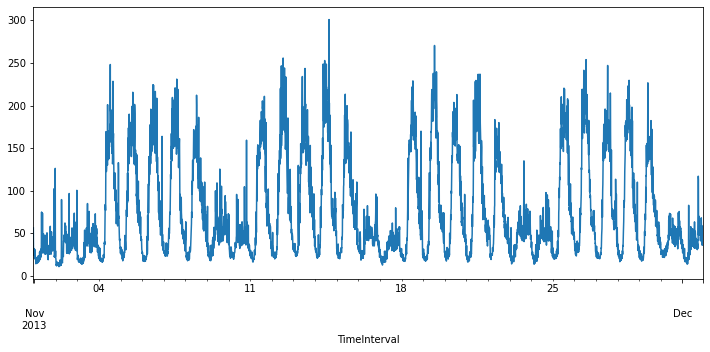

In [4]:
df['InternetActivity'].plot(figsize=(12,5));

## Split data

In [5]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

3571 893


## Scaling Data

In [6]:
# Can add more columns here
#f_columns = ['InternetActivity']

#f_transformer = RobustScaler()
internet_transformer = RobustScaler()

#f_transformer = f_transformer.fit(train[f_columns].to_numpy())
internet_transformer = internet_transformer.fit(train[['InternetActivity']])

#train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['InternetActivity'] = internet_transformer.transform(train[['InternetActivity']])

#test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['InternetActivity'] = internet_transformer.transform(test[['InternetActivity']])

C:\Users\shahi\AppData\Local\Temp/ipykernel_20256/117993029.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['InternetActivity'] = internet_transformer.transform(train[['InternetActivity']])
C:\Users\shahi\AppData\Local\Temp/ipykernel_20256/117993029.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['InternetActivity'] = internet_transformer.transform(test[['InternetActivity']])


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
# The number of past values considered in the LSTM
time_steps = 12

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train['InternetActivity'], time_steps)
X_test, y_test = create_dataset(test, test['InternetActivity'], time_steps)

print(X_train.shape, y_train.shape)

(3559, 12, 1) (3559,)


## Keras model

In [9]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/20
101/101 [==============================] - 1s 5ms/step - loss: 0.1914 - val_loss: 0.0394
Epoch 2/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0343
Epoch 3/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0350
Epoch 4/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0443 - val_loss: 0.0299
Epoch 5/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0292
Epoch 6/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0289
Epoch 7/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0289
Epoch 8/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0406 - val_loss: 0.0286
Epoch 9/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0402 - val_loss: 0.0284
Epoch 10/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.0281

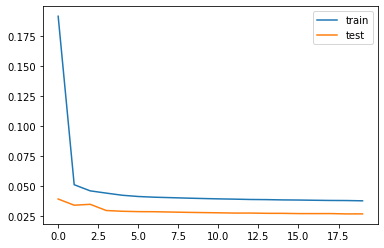

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Predictions

In [13]:
y_pred = model.predict(X_test)

In [14]:
y_train_inv = internet_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = internet_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = internet_transformer.inverse_transform(y_pred)

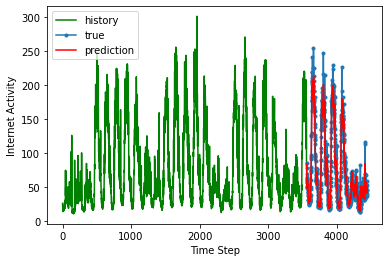

In [15]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Internet Activity')
plt.xlabel('Time Step')
plt.legend()
plt.show();

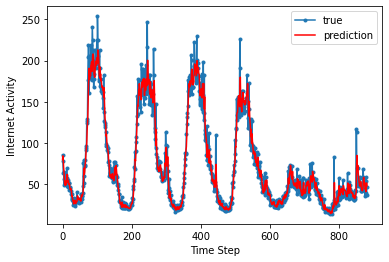

In [16]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Internet Activity')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [17]:
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print(rmse)

13.802421321816212


## Save data to folder

In [18]:
# PREDICTIONS

# Convert predictions to numpy array
arr = np.array(y_pred_inv.flatten())

# Change name to describe experiment: LSTM_<data_length[100,50,12]>_<grid_x>_<grid_y>
# ----------------------------------------
filename = "LSTM_50_70_80.npy"
# ----------------------------------------

folder_name = "../results/LSTM/predictions"
f = os.path.join(folder_name, filename)
np.save(f, arr)

# MODEL HISTORY

# Change name to describe experiment: LSTM_HISTORY_<data_length[100,50,12]>_<grid_x>_<grid_y>
# ----------------------------------------
filename = "LSTM_HISTORY_50_70_80.npy"
# ----------------------------------------

folder_name = "../results/LSTM/training"
f = os.path.join(folder_name, filename)
np.save(f,history.history)

## Load data to test

In [7]:
data = np.load("../results/LSTM/predictions/LSTM_100_50_50.npy")

history=np.load("../results/LSTM/training/LSTM_HISTORY_100_50_50.npy",allow_pickle='TRUE').item()

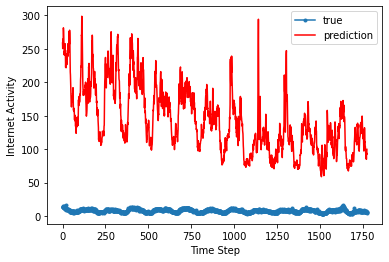

In [21]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(data, 'r', label="prediction")
plt.ylabel('Internet Activity')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), data))
print(rmse)

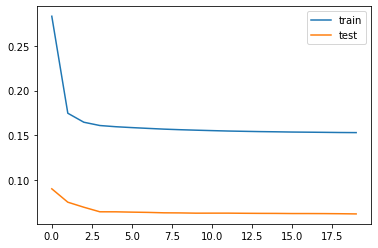

In [9]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend();

Seems to work fine!